# I. Data Cleaning and Pre-processing

We found this dataset from Kaggle, and it contains 114k rows of data. Similar to the dataset we originally pulled from the Spotify API, it contains quantitative audio metrics and track ID information, but this dataset was cleaned to represent only one top genre that the song belongs to. Presumably, this was pulled from a playlist of the top genre, as we planned to do before Spotify removed this functionality in their API. To simplify our model and also remove genres that are similar, we need to clean the bigger csv before training our models. The genres we selected were initially based on what we thought was musically different, but later was adjusted to improve accuracy of our model as we better understood the quantitative audio metrics.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy.stats as stats
rng_seed = 454
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [ ]:
filename = 'train.csv'
data = pd.read_csv(filename)
data.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

We will be using columns #8-18 as our audio features to train the genre classification models.

In [ ]:
data.track_genre.value_counts()

,count
track_genre,
acoustic,1000
punk-rock,1000
progressive-house,1000
power-pop,1000
pop,1000
...,...
folk,1000
emo,1000
electronic,1000


Each of the 114 original genres has 1000 songs, or rows of data. We are proceeding with only a selected handful of genres that are variable enough to be picked up by these audio features.

We decided to procees with the following 16 genres after some trial-and-error.

In [ ]:
genres_to_keep = [
    'acoustic', 'afrobeat', 'blues', 'classical',
    'country', 'disco', 'edm', 'folk', 'hip-hop',
    'house','jazz', 'metal', 'pop', 'r-n-b', 'reggae',
    'rock'
]

In [ ]:
if 'track_genre' in data.columns:
    cleaned_data = data[data['track_genre'].isin(genres_to_keep)]
    print(f"Cleaned dataset now has {cleaned_data.shape[0]} rows.")

Cleaned dataset now has 16000 rows.


# II. Machine Learning Models

We chose to explore using 4 different models: Random Forest, Multinomial Regression, Naive Bayes, and a Neural Network.

In [ ]:
audio = cleaned_data[['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness' , 'liveness', 'valence', 'tempo']]
target = cleaned_data['track_genre']

20% test, 80% train

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(audio,
                                                target,
                                                test_size=0.2,
                                                random_state=rng_seed )

### II.i Random Forest

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

In [ ]:
Xtrainrf, Xtestrf, ytrainrf, ytestrf = train_test_split(audio,
                                                target_encoded,
                                                test_size=0.2,
                                                random_state=rng_seed )

In [ ]:
scaler = StandardScaler()
Xtrainscaledrf = scaler.fit_transform(Xtrainrf)
Xtestscaledrf = scaler.transform(Xtestrf)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=rng_seed)
model.fit(Xtrainscaledrf, ytrainrf)

RandomForestClassifier(random_state=454)

In [ ]:
ypredrf = model.predict(Xtestscaledrf)

In [ ]:
accuracy_rf = accuracy_score(ytestrf, ypredrf)
print(f"Accuracy: {accuracy_rf:.4f}")

Accuracy: 0.4400


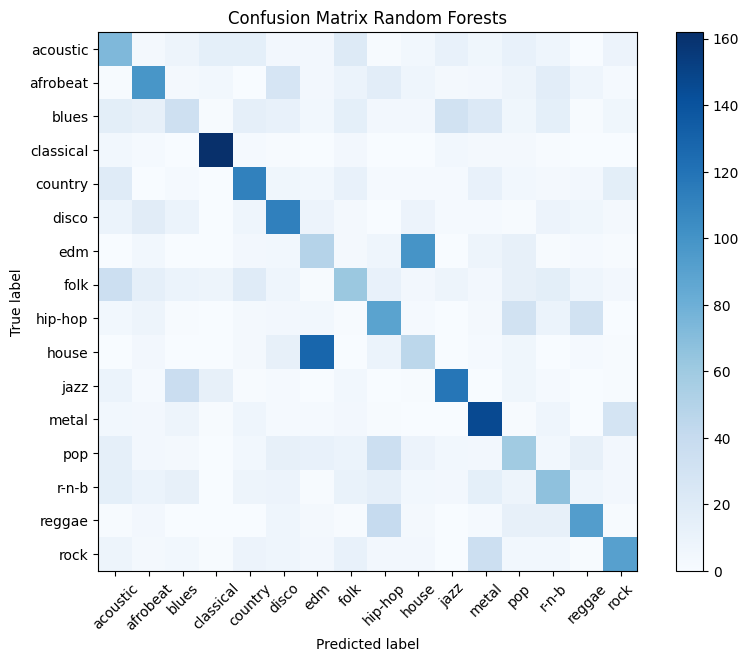

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
category_names = label_encoder.classes_
cm_RF = confusion_matrix(ytestrf, ypredrf)

tick_marks = np.arange(len(label_encoder.classes_))
plt.figure(figsize=(10, 7))
plt.imshow(cm_RF, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix Random Forests')
plt.colorbar()
plt.xticks(tick_marks, category_names, rotation=45)
plt.yticks(tick_marks, category_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
TPR_RF = []
TNR_RF = []
for i in range(len(model.classes_)):
    TP = cm_RF[i, i]  # True Positives for class i
    FN = cm_RF[i, :].sum() - TP  # False Negatives for class i
    FP = cm_RF[:, i].sum() - TP  # False Positives for class i
    TN = cm_RF.sum() - (TP + FN + FP)  # True Negatives for class i


    TPR_RF.append(TP / (TP + FN) if (TP + FN) > 0 else 0)
    TNR_RF.append(TN / (TN + FP) if (TN + FP) > 0 else 0)


NB_table = pd.DataFrame({
    'Class': label_encoder.classes_,
    'True Positive Rate': TPR_RF,
    'True Negative Rate': TNR_RF
})
NB_table_sorted = NB_table.sort_values(by='True Positive Rate', ascending=False)

# Display the table
print(NB_table_sorted)

        Class  True Positive Rate  True Negative Rate
3   classical            0.861702            0.985392
11      metal            0.672811            0.959102
10       jazz            0.595960            0.976016
5       disco            0.557214            0.960320
4     country            0.552239            0.967656
14     reggae            0.513812            0.973170
15       rock            0.469072            0.973054
8     hip-hop            0.461140            0.951114
1    afrobeat            0.460094            0.968530
0    acoustic            0.374359            0.952080
13      r-n-b            0.350785            0.963111
12        pop            0.302564            0.956406
7        folk            0.276786            0.962366
6         edm            0.248731            0.939061
9       house            0.210280            0.948426
2       blues            0.166667            0.966689


### II.ii Multinomial Regression

In [ ]:
# import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# standardizing Xtrain
X = StandardScaler().fit_transform(Xtrain)
Xtrain_norm = pd.DataFrame(X, index=Xtrain.index, columns=Xtrain.columns)

# encoding target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(ytrain)
y_encoded = pd.Series(y_encoded, index=Xtrain.index)


# selecting best single feature
col = (Xtrain.corrwith(y_encoded))
best_single_feature = col.idxmax()


# logistic regression: single feature
# without normalization
model_nonorm = LogisticRegression(random_state=rng_seed)
model_nonorm.fit(Xtrain[[best_single_feature]], ytrain)
# with normalization
model_norm = LogisticRegression(random_state=rng_seed)
model_norm.fit(Xtrain_norm[[best_single_feature]], ytrain)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=rng_seed))
])
pipeline.fit(Xtrain[[best_single_feature]], ytrain)

# cross-validation accuracy (single feature models)
acc_nonorm = np.mean(cross_val_score(model_nonorm, Xtrain[[best_single_feature]], ytrain, scoring='accuracy', cv=3))
acc_norm = np.mean(cross_val_score(model_norm, Xtrain_norm[[best_single_feature]], ytrain, scoring='accuracy', cv=3))
acc_pipe = np.mean(cross_val_score(pipeline, Xtrain[[best_single_feature]], ytrain, scoring='accuracy', cv=3))


#logistic Regression: all features
C = np.logspace(-2, 2, 25)
acc = np.empty(25)
models = list()

#best regularization parameter
for c in range(len(C)):
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(C=C[c], penalty='l1', solver='liblinear', random_state=rng_seed))
    ])
    model.fit(Xtrain, ytrain)
    models.append(model)
    acc[c] = cross_val_score(model, Xtrain, ytrain, cv=3, scoring='accuracy').mean()

# best C value
cstar = np.argmax(acc)
acc_star = acc[cstar]
theta = np.vstack([model.named_steps['logreg'].coef_[0, :] for model in models])
theta_star = theta[cstar, :]
features = Xtrain.columns
best_features = features[theta_star != 0]
max_idx = np.argmax(theta_star)
max_theta_feature = features[max_idx]

# best model
lasso_model = models[cstar]
yhat = lasso_model.predict(Xtest)
lasso_test = accuracy_score(ytest, yhat)


# results for single feature models
print(f"Single Feature (Non-Normalized):")
print(f"  Feature: {best_single_feature}")
print(f"  Test Accuracy: {acc_nonorm:.3f}")

print(f"\nSingle Feature (Normalized):")
print(f"  Feature: {best_single_feature}")
print(f"  Test Accuracy: {acc_norm:.3f}")

# results for Lasso model
print(f"\nAll Features with Regularization:")
print(f"  Best Regularization Parameter (C): {C[cstar]:.3f}")
print(f"  Cross-Validation Accuracy: {acc_star:.3f}")
print(f"  Test Accuracy: {lasso_test:.3f}")


Single Feature (Non-Normalized):
  Feature: loudness
  Test Accuracy: 0.147

Single Feature (Normalized):
  Feature: loudness
  Test Accuracy: 0.147

All Features with Regularization:
  Best Regularization Parameter (C): 0.316
  Cross-Validation Accuracy: 0.315
  Test Accuracy: 0.310


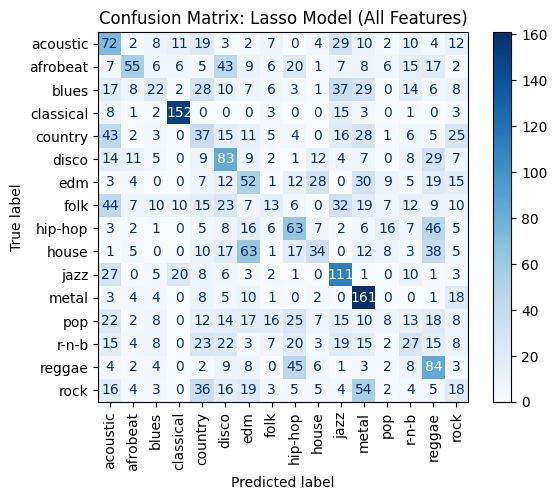

Lasso Model Confusion Matrix Metrics:
        Class  True Positive Rate  True Negative Rate
3   classical            0.808511            0.983732
11      metal            0.741935            0.921220
10       jazz            0.560606            0.939707
14     reggae            0.464088            0.929447
5       disco            0.412935            0.932311
0    acoustic            0.369231            0.924459
8     hip-hop            0.326425            0.947123
6         edm            0.263959            0.938728
1    afrobeat            0.258216            0.980583
4     country            0.184080            0.937646
9       house            0.158879            0.974548
13      r-n-b            0.141361            0.961449
2       blues            0.111111            0.977682
15       rock            0.092784            0.956088
7        folk            0.058036            0.977823
12        pop            0.041026            0.981697


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


yhat_lasso = lasso_model.predict(Xtest)

# confusion matrix
cm_lasso = confusion_matrix(ytest, yhat_lasso, labels=lasso_model.named_steps['logreg'].classes_)
disp_lasso = ConfusionMatrixDisplay(confusion_matrix=cm_lasso, display_labels=lasso_model.named_steps['logreg'].classes_)
disp_lasso.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix: Lasso Model (All Features)")
plt.show()

TPR_R = []
TNR_R = []

for i in range(len(lasso_model.named_steps['logreg'].classes_)):
    TP = cm_lasso[i, i]  # true postivies
    FN = cm_lasso[i, :].sum() - TP  # false negative
    FP = cm_lasso[:, i].sum() - TP  # false positives
    TN = cm_lasso.sum() - (TP + FN + FP)  # true negatives

    TPR_R.append(TP / (TP + FN) if (TP + FN) > 0 else 0)
    TNR_R.append(TN / (TN + FP) if (TN + FP) > 0 else 0)

# TPR and TNR for lasso
table = pd.DataFrame({
    'Class': lasso_model.named_steps['logreg'].classes_,
    'True Positive Rate': TPR_R,
    'True Negative Rate': TNR_R
})
table_sorted = table.sort_values(by='True Positive Rate', ascending=False)

# table
print("Lasso Model Confusion Matrix Metrics:")
print(table_sorted)

### II.iii Naive Bayes

In [ ]:
scaler = MinMaxScaler()
Xtrain_scaled_NB = scaler.fit_transform(Xtrain)
Xtest_scaled_NB = scaler.transform(Xtest)

In [ ]:
model = MultinomialNB()
model.fit(Xtrain_scaled_NB, ytrain)

MultinomialNB()

In [ ]:
from sklearn.metrics import accuracy_score

ypred = model.predict(Xtest_scaled_NB)
accuracy_nb = accuracy_score(ytest, ypred)

print("Accuracy:", accuracy_score(ytest, ypred))


Accuracy: 0.2471875


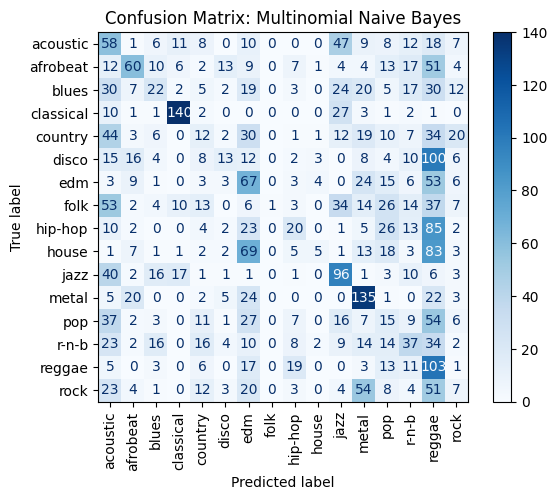

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_NB = confusion_matrix(ytest, ypred, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_NB, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix: Multinomial Naive Bayes")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytest, ypred, labels=model.classes_)

TPR_NB = []
TNR_NB = []
for i in range(len(model.classes_)):
    TP = cm_NB[i, i]  # True Positives for class i
    FN = cm_NB[i, :].sum() - TP  # False Negatives for class i
    FP = cm_NB[:, i].sum() - TP  # False Positives for class i
    TN = cm_NB.sum() - (TP + FN + FP)  # True Negatives for class i


    TPR_NB.append(TP / (TP + FN) if (TP + FN) > 0 else 0)
    TNR_NB.append(TN / (TN + FP) if (TN + FP) > 0 else 0)


NB_table = pd.DataFrame({
    'Class': model.classes_,
    'True Positive Rate': TPR_NB,
    'True Negative Rate': TNR_NB
})
NB_table_sorted = NB_table.sort_values(by='True Positive Rate', ascending=False)

# Display the table
print(NB_table_sorted)


        Class  True Positive Rate  True Negative Rate
3   classical            0.744681            0.984396
11      metal            0.622120            0.933624
14     reggae            0.569061            0.781716
10       jazz            0.484848            0.940373
6         edm            0.340102            0.907759
0    acoustic            0.297436            0.896506
1    afrobeat            0.281690            0.973887
13      r-n-b            0.193717            0.955135
2       blues            0.111111            0.976016
8     hip-hop            0.103627            0.979381
12        pop            0.076923            0.945092
5       disco            0.064677            0.987329
4     country            0.059701            0.968323
15       rock            0.036082            0.972721
9       house            0.023364            0.996316
7        folk            0.004464            1.000000


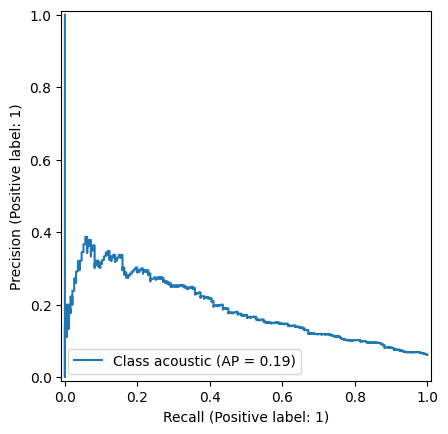

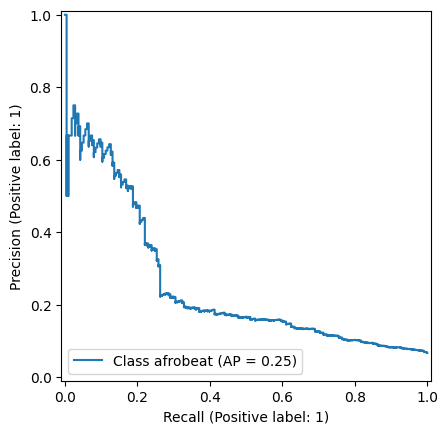

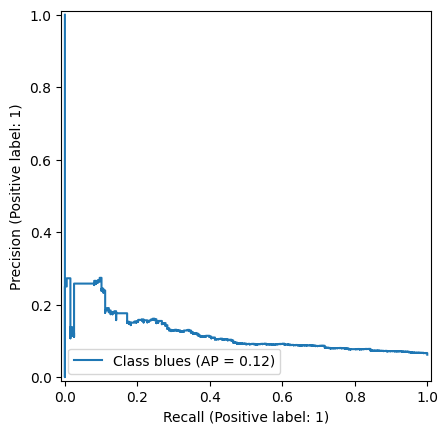

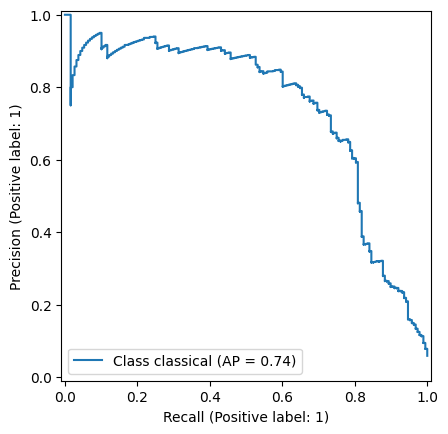

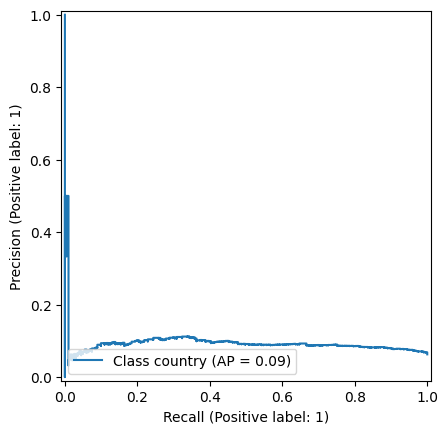

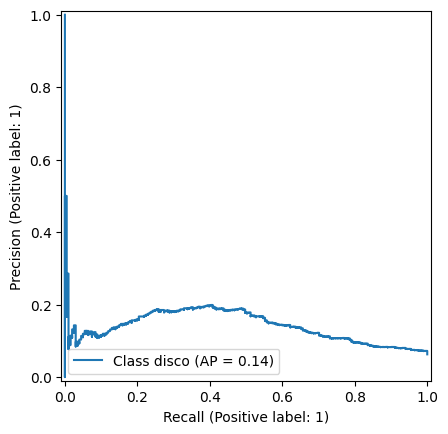

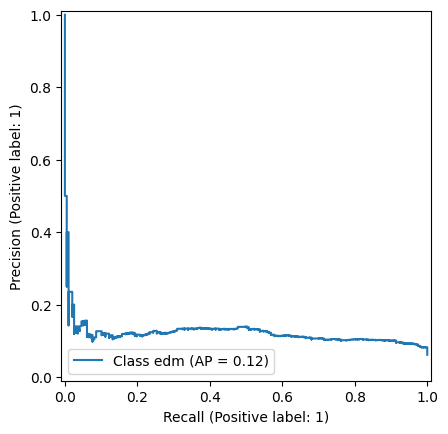

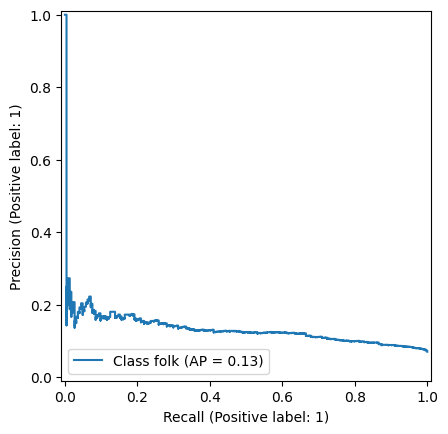

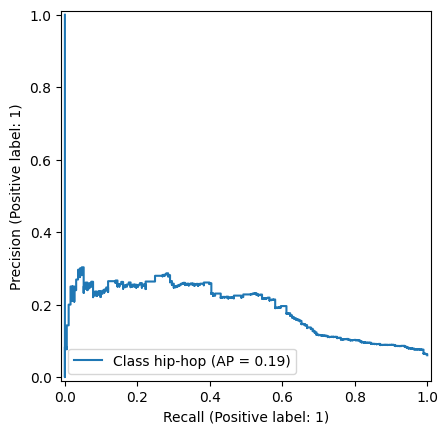

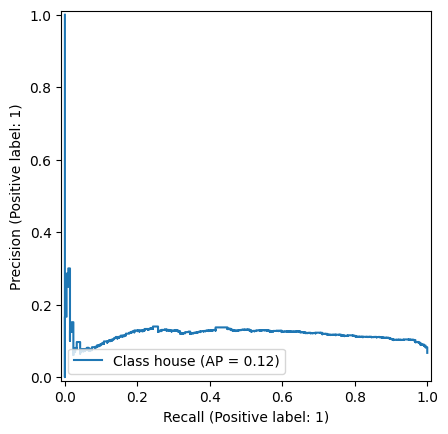

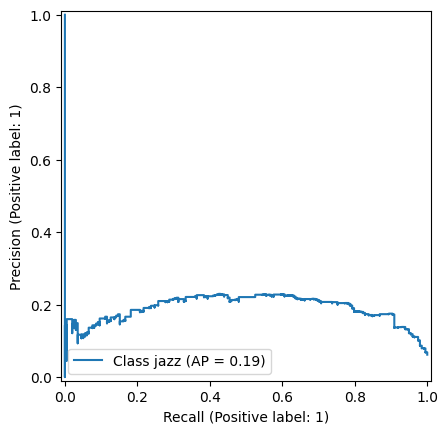

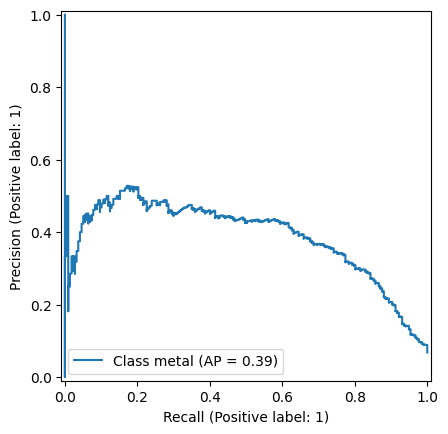

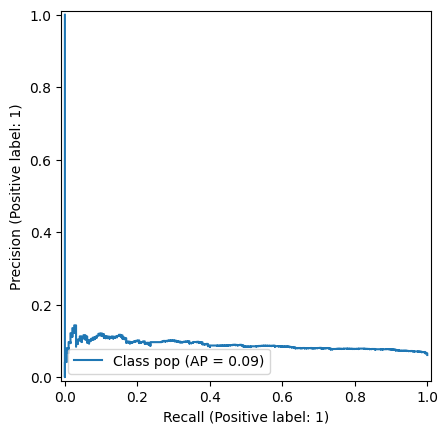

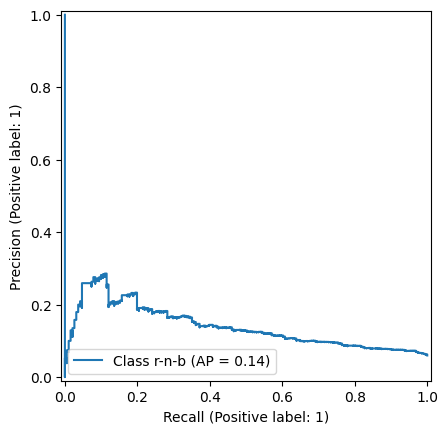

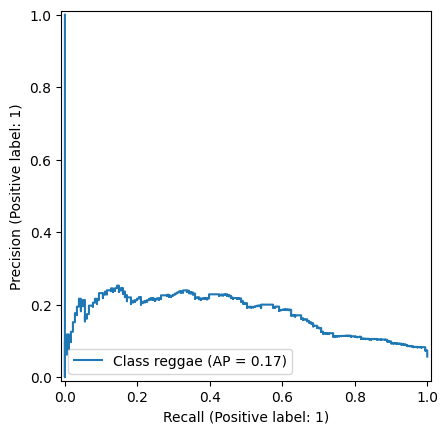

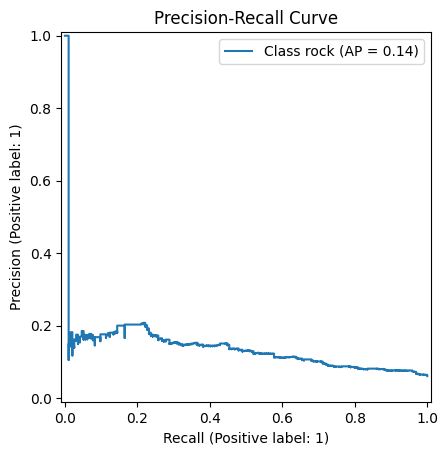

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

yprobs = model.predict_proba(Xtest_scaled_NB)

for i, label in enumerate(model.classes_):
    disp = PrecisionRecallDisplay.from_predictions(
        (ytest == label).astype(int),
        yprobs[:, i],
        name=f"Class {label}",
    )
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()

### II.iv Neural Network

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

In [ ]:
X = cleaned_data[['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness' , 'liveness', 'valence', 'tempo']]
y = cleaned_data['track_genre']

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

y_ohe = to_categorical(y_encoded)

In [ ]:
model = Sequential([
    Dense(12,input_dim=10,activation='relu'),
    Dense(12,activation='relu'),
    Dense(16,activation='softmax'),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 12)                  │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 496 (1.94 KB)

 Trainable params: 496 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Xtrain,Xval,ytrain,yval = train_test_split(X,y, test_size=0.2, shuffle=True)

le = LabelEncoder()
ytrain_encoded = le.fit_transform(ytrain)
yval_encoded = le.transform(ytest)

ytrain_ohe = to_categorical(ytrain_encoded)
yval_ohe = to_categorical(yval_encoded)

In [ ]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
trainhist = model.fit(Xtrain,ytrain_ohe,
                      epochs=100,
                      batch_size=32,
                      validation_data = (Xtest,yval_ohe))

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0792 - loss: 9.5062 - val_accuracy: 0.1081 - val_loss: 2.7372
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1094 - loss: 2.7078 - val_accuracy: 0.1028 - val_loss: 2.6616
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1185 - loss: 2.6472 - val_accuracy: 0.1088 - val_loss: 2.6175
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1300 - loss: 2.5952 - val_accuracy: 0.1406 - val_loss: 2.5575
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1476 - loss: 2.5411 - val_accuracy: 0.1453 - val_loss: 2.5069
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1581 - loss: 2.5091 - val_accuracy: 0.1447 - val_loss: 2.4821
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1667 - loss: 2.4775 - val_accuracy: 0.1681 - val_loss: 2.4605
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1780 - loss: 2.4538 - val_accu

Text(0.5, 0, 'Epochs')

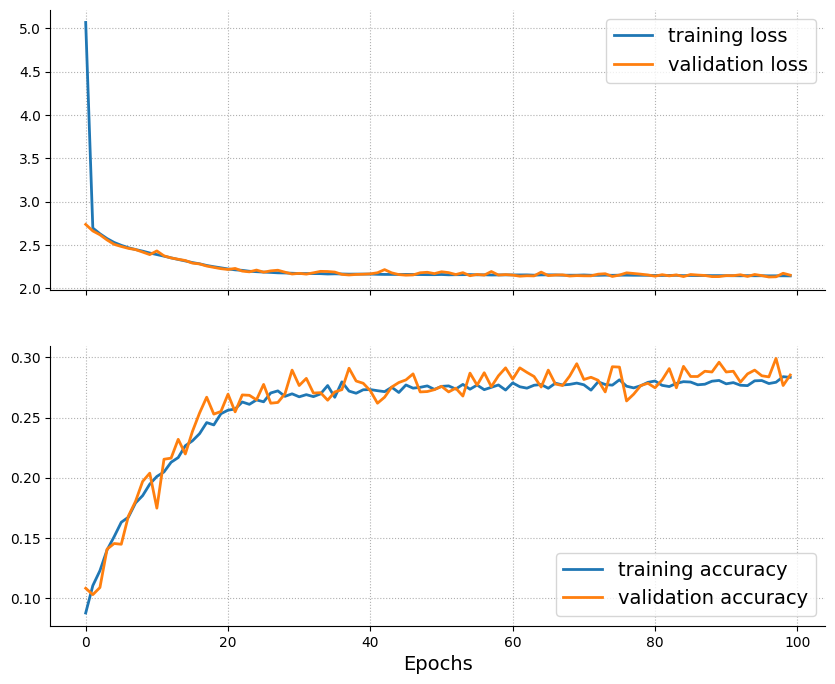

In [ ]:
fig, axs = plt.subplots(figsize=(10,8),nrows=2,sharex=True)

ax=axs[0]
ax.plot(trainhist.history['loss'],linewidth=2,label='training loss')
ax.plot(trainhist.history['val_loss'],linewidth=2,label='validation loss')
ax.grid(linestyle=':')
ax.legend(fontsize=14)
ax.spines[['top','right']].set_visible(False)

ax=axs[1]
ax.plot(trainhist.history['accuracy'],linewidth=2,label='training accuracy')
ax.plot(trainhist.history['val_accuracy'],linewidth=2,label='validation accuracy')
ax.grid(linestyle=':')
ax.legend(fontsize=14)
ax.spines[['top','right']].set_visible(False)

plt.xlabel('Epochs',fontsize=14)

# III. Performance and Comparison of Models

In this section we will concisely compare accuracies, TPR, and TNR calculated above.

Comparing Accuracies:

In [ ]:
table_acc = pd.DataFrame({'Accuracy': [accuracy_nb, acc_star, accuracy_rf]},
                          index=['Naive Bayes', 'Multinomial Regression', 'Random Forest'])

print(table_acc)

                        Accuracy
Naive Bayes             0.247188
Multinomial Regression  0.314765
Random Forest           0.440000


With this table, we want to see which model boasts the highest TPR rates, and which the worst by category (genre).

In [ ]:
table = pd.DataFrame(index=label_encoder.classes_)

table['TPR: Naive Bayes'] = TPR_NB
table['TPR: Multinomial Regression'] = TPR_R
table['TPR: Random Forest'] = TPR_RF


def highlight_best_worst(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: green' if v else 'background-color: red' if w else '' for v, w in zip(is_max, is_min)]

table_styled = table.style.apply(highlight_best_worst, axis=1).set_caption('TPR Comparison')

display(table_styled)


,TPR: Naive Bayes,TPR: Multinomial Regression,TPR: Random Forest
acoustic,0.297436,0.369231,0.374359
afrobeat,0.281690,0.258216,0.460094
blues,0.111111,0.111111,0.166667
classical,0.744681,0.808511,0.861702
country,0.059701,0.184080,0.552239
disco,0.064677,0.412935,0.557214
edm,0.340102,0.263959,0.248731
folk,0.004464,0.058036,0.276786
hip-hop,0.103627,0.326425,0.461140
house,0.023364,0.158879,0.210280


With this table, we want to see which model boasts the highest TNR rates, and which the worst by category (genre).

In [ ]:
table2 = pd.DataFrame(index=label_encoder.classes_)

table2['TNR: Naive Bayes'] = TNR_NB
table2['TNR: Multinomial Regression'] = TNR_R
table2['TNR: Random Forest'] = TNR_RF


def highlight_best_worst(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: green' if v else 'background-color: red' if w else '' for v, w in zip(is_max, is_min)]

table2_styled = table2.style.apply(highlight_best_worst, axis=1).set_caption('TNR Comparison')

display(table2_styled)

,TNR: Naive Bayes,TNR: Multinomial Regression,TNR: Random Forest
acoustic,0.896506,0.924459,0.952080
afrobeat,0.973887,0.980583,0.968530
blues,0.976016,0.977682,0.966689
classical,0.984396,0.983732,0.985392
country,0.968323,0.937646,0.967656
disco,0.987329,0.932311,0.960320
edm,0.907759,0.938728,0.939061
folk,1.000000,0.977823,0.962366
hip-hop,0.979381,0.947123,0.951114
house,0.996316,0.974548,0.948426


With this table, we want to see which genre was the easiest, and which was the hardest for each model to predict.

In [ ]:
table3 = pd.DataFrame(index=label_encoder.classes_)

table3['TPR: Naive Bayes'] = TPR_NB
table3['TPR: Multinomial Regression'] = TPR_R
table3['TPR: Random Forest'] = TPR_RF

def highlight_best_worst(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: green' if v else 'background-color: red' if w else '' for v, w in zip(is_max, is_min)]

table3_styled = table3.style.apply(highlight_best_worst, axis=0).set_caption(f'<h2 style="font-weight: bold; font-size: 16px;">Best and Worst Genre Predicted by Model</h2>')

display(table3_styled)

,TPR: Naive Bayes,TPR: Multinomial Regression,TPR: Random Forest
acoustic,0.297436,0.369231,0.374359
afrobeat,0.281690,0.258216,0.460094
blues,0.111111,0.111111,0.166667
classical,0.744681,0.808511,0.861702
country,0.059701,0.184080,0.552239
disco,0.064677,0.412935,0.557214
edm,0.340102,0.263959,0.248731
folk,0.004464,0.058036,0.276786
hip-hop,0.103627,0.326425,0.461140
house,0.023364,0.158879,0.210280
